In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from os.path import join as pjoin
from scipy.io import mmread
import scanpy as sc
import anndata
import squidpy as sq

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def rotate_90deg_counterclockwise(coords):
    y_coords_reflected = -coords[:, 1] - coords[:, 1].max()
    return np.vstack([y_coords_reflected, coords[:, 0]]).T

In [3]:
DATA_DIR = "../../../data/mouse_brain_slideseq/12_allMTXs_CCF/"

In [4]:
metadata_slice1 = pd.read_table(pjoin(DATA_DIR, "MBASS_d1_metadata.tsv"))
metadata_slice2 = pd.read_table(pjoin(DATA_DIR, "MBASS_d3_metadata.tsv"))

data_sparse_slice1 = mmread(pjoin(DATA_DIR, "MBASS_d1_matrix.mtx"))
data_sparse_slice2 = mmread(pjoin(DATA_DIR, "MBASS_d3_matrix.mtx"))

data_slice1 = data_sparse_slice1.toarray()
data_slice2 = data_sparse_slice2.toarray()

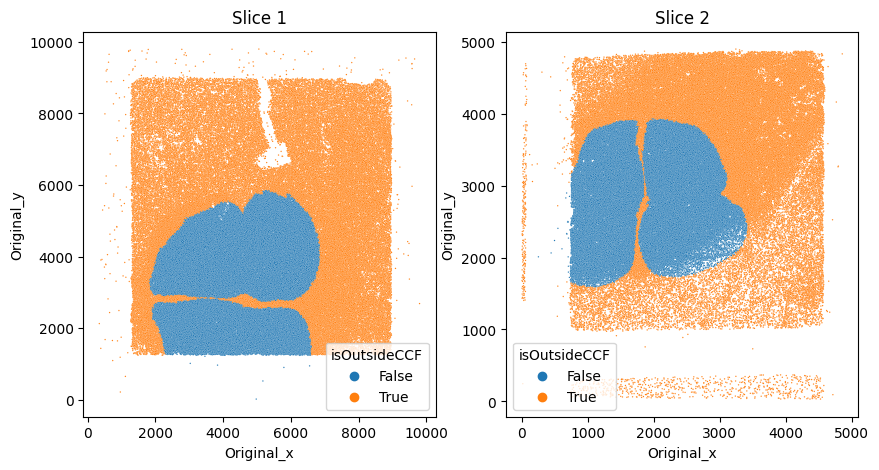

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.scatterplot(data=metadata_slice1, x="Original_x", y="Original_y", s=1, hue="isOutsideCCF")
plt.title("Slice 1")
plt.subplot(122)
sns.scatterplot(data=metadata_slice2, x="Original_x", y="Original_y", s=1, hue="isOutsideCCF")
plt.title("Slice 2")
plt.show()

In [6]:
num_zeros_per_gene = (data_slice1 == 0).sum(1)

In [7]:
sorted_idx = np.argsort(num_zeros_per_gene)
n_genes = 50

In [8]:
rotated_coords_slice1 = rotate_90deg_counterclockwise(rotate_90deg_counterclockwise(rotate_90deg_counterclockwise(metadata_slice1[["Original_x", "Original_y"]].values)))
X_slice1 = rotated_coords_slice1[~metadata_slice1.isOutsideCCF]
X_slice2 = metadata_slice2.loc[~metadata_slice2.isOutsideCCF, ["Original_x", "Original_y"]].values

Y_slice1 = data_slice1.T[~metadata_slice1.isOutsideCCF.values, sorted_idx[8]]
Y_slice2 = data_slice2.T[~metadata_slice2.isOutsideCCF.values, sorted_idx[8]]


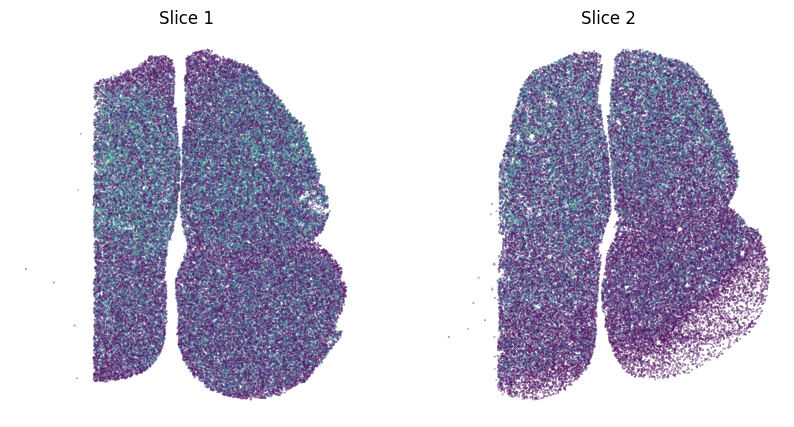

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_slice1[:, 0], X_slice1[:, 1], c=np.log(Y_slice1 + 1), s=.05)
plt.title("Slice 1")
plt.axis("off")

plt.subplot(122)
plt.scatter(X_slice2[:, 0], X_slice2[:, 1], c=np.log(Y_slice2 + 1), s=.05)
plt.title("Slice 2")
plt.axis("off")
plt.show()

In [10]:
# curr_slice = anndata.AnnData(data_slice1.T[~metadata_slice1.isOutsideCCF.values, :10])
in_slice_idx = np.where(~metadata_slice1.isOutsideCCF.values)[0]
in_slice_idx = np.random.choice(in_slice_idx, size=10_000, replace=False)

X_slice1 = rotated_coords_slice1[in_slice_idx]
Y_slice1 = data_slice1.T[in_slice_idx, :10_000]
Y_slice1 = Y_slice1[:, Y_slice1.sum(0) > 0]
curr_slice = anndata.AnnData(Y_slice1)
curr_slice.obsm['spatial'] = X_slice1

<ipython-input-10-dcf65ead8043>:8: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  curr_slice = anndata.AnnData(Y_slice1)


In [11]:
sq.gr.spatial_neighbors(curr_slice)
sq.gr.spatial_autocorr(
    curr_slice,
    mode="moran",
)

In [12]:
display(curr_slice.uns["moranI"].sort_values("I", ascending=False))
moran_idx_sorted = curr_slice.uns["moranI"].index.values.astype(int)

I  pval_norm  var_norm  pval_norm_fdr_bh
6530  0.303513   0.000000  0.000034          0.000000
2391  0.270183   0.000000  0.000034          0.000000
7198  0.239555   0.000000  0.000034          0.000000
3567  0.193588   0.000000  0.000034          0.000000
5385  0.183330   0.000000  0.000034          0.000000
...        ...        ...       ...               ...
6904 -0.009093   0.061084  0.000034          0.177073
1501 -0.009232   0.058251  0.000034          0.170127
6392 -0.009617   0.050927  0.000034          0.152159
2492 -0.010203   0.041237  0.000034          0.127523
5526 -0.010338   0.039221  0.000034          0.122083

[7595 rows x 4 columns]

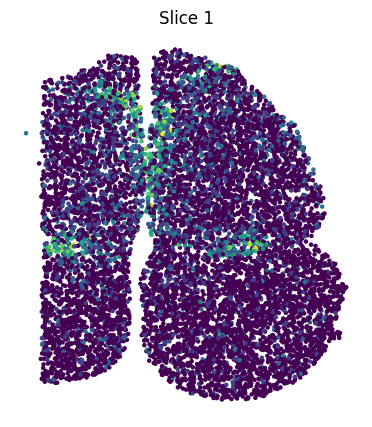

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(curr_slice.obsm["spatial"][:, 0], curr_slice.obsm["spatial"][:, 1], c=np.log(curr_slice.X[:, moran_idx_sorted[0]] + 1), s=5)
plt.title("Slice 1")
plt.axis("off")

# plt.subplot(122)
# plt.scatter(X_slice2[:, 0], X_slice2[:, 1], c=np.log(Y_slice2 + 1), s=.05)
# plt.title("Slice 2")
# plt.axis("off")
plt.show()